# Load dependencies
- Change oversample indices

In [1]:
import os
os.getcwd()
os.chdir('/tf/notebooks/ruez/stroke_bern')

In [2]:
!pip install tabulate

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# from PIL import Image
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
# from scipy import ndimage
from scipy import ndimage
from scipy.special import expit, logit

from skimage import exposure
import sklearn.metrics as skm
from tabulate import tabulate

# Tensorflow/Keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
print(tf.__version__) #2.4.0
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.utils import to_categorical
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Own functions
from functions.plot_slices import plot_slices
from functions.CNN_architecture import Conv2Plus1D
from functions.keras_training_progress import PlotLearning
# ontram functions
from k_ontram_functions.ontram import ontram
from k_ontram_functions.ontram_loss import ontram_loss
from k_ontram_functions.ontram_metrics import ontram_acc, ontram_auc
from k_ontram_functions.ontram_predict import predict_ontram, get_parameters

from functions.augmentation3d import zoom, rotate, flip, shift

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ihss3yzs because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


2.4.0


In [4]:
# Define the path + output path:
# os.getcwd()
DIR = "/tf/notebooks/"
DATA_DIR = "ruez/stroke_bern/data/"
OUTPUT_DIR = "/tf/notebooks/ruez/stroke_bern/callbacks/ontrams_3d_resent_clinical_dwi/"

# Import images

In [5]:
with h5py.File(DIR + DATA_DIR + "data_bern_25_11_2020_preprocessed.h5", "r") as h5:
    X0 = h5["X_dwi"][:]
print(X0.shape, X0.min(), X0.max(), X0.mean(), X0.std()) # patients, coronal, sagittal, axial, channels

(222, 128, 128, 64, 1) -7.217837989522173 39.758812613731685 -3.158197493145928 1.8809703357091876


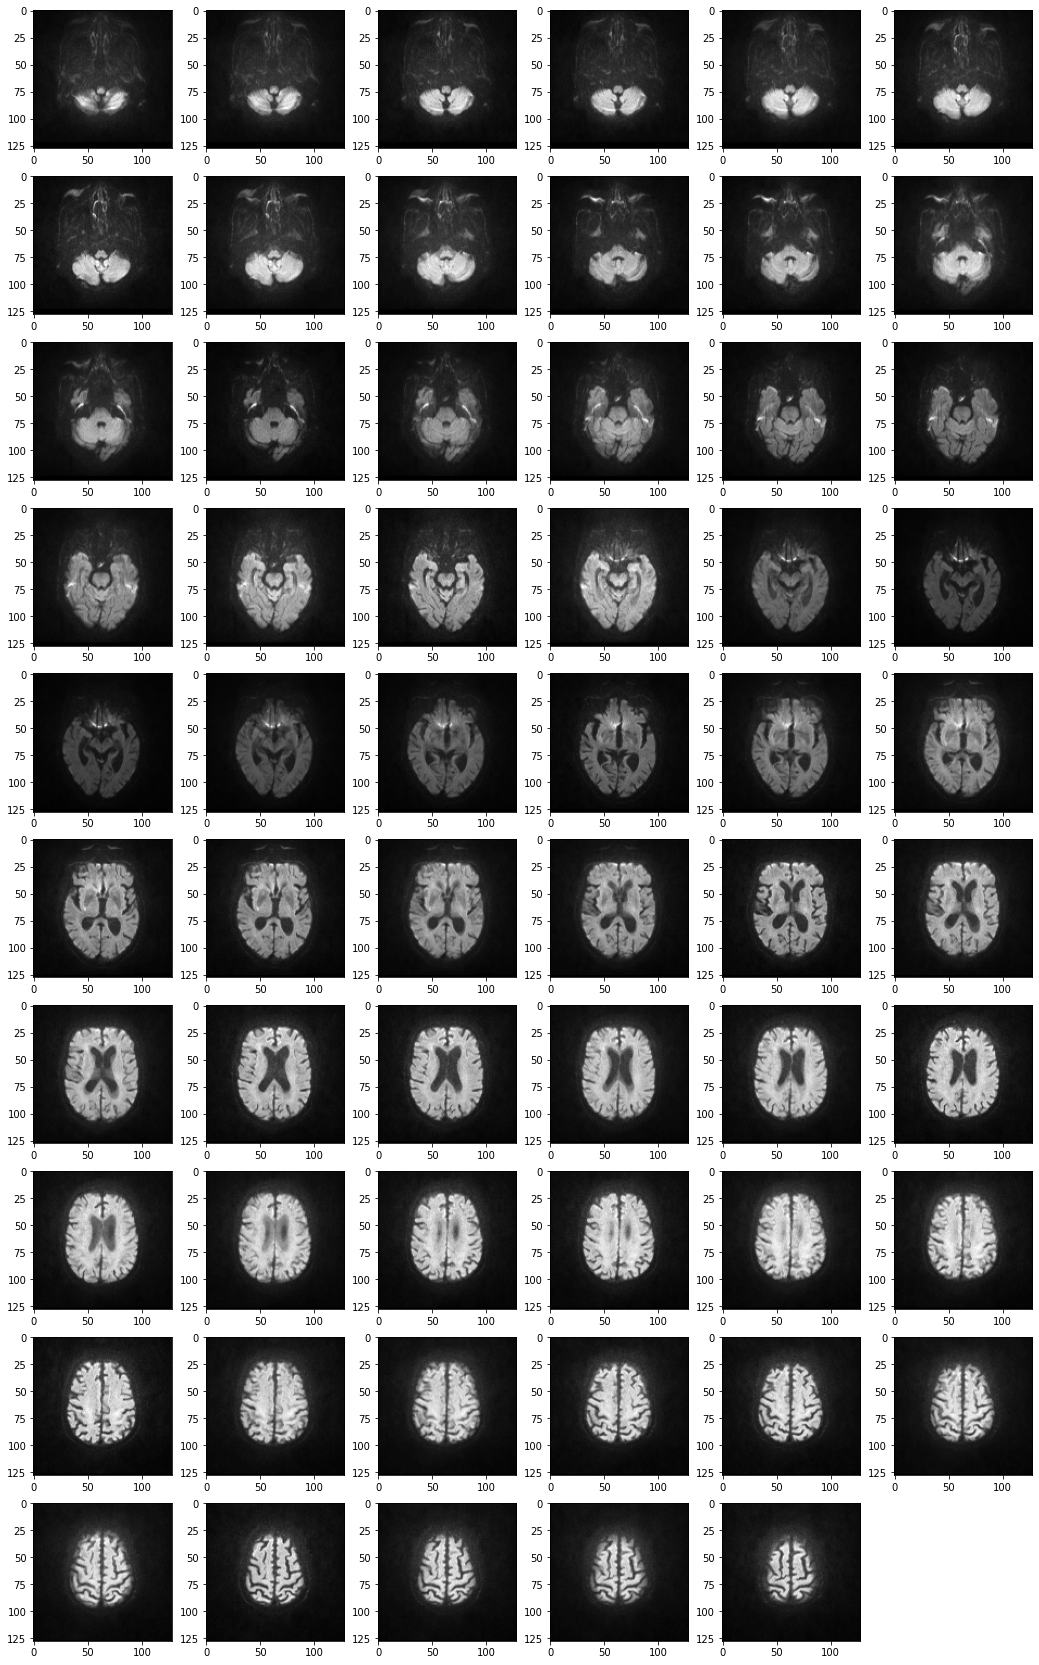

In [6]:
plot_slices(X0[0], 0, "axial", modality = "DWI") # e.g. patient 0

#### Reduce images per patient

In [6]:
# Reshape the data to reduce images per patient
print('old shape: ', X0[0].shape[:]) # original shape
dim = (128, 128, 20, 1) # target shape

X = np.empty((len(X0), 128, 128, 20, 3))
for i in range(len(X0)):
    scaling_factor = [dim[0]/X0[i].shape[0], dim[1]/X0[i].shape[1], dim[2]/X0[i].shape[2], dim[3]/X0[i].shape[3]]
    X[i,:,:,:,:] = ndimage.zoom(X0[i], scaling_factor, order = 1)
X[:,:,:,:,1] = X[:,:,:,:,0]
X[:,:,:,:,2] = X[:,:,:,:,0]
print('target shape: ', dim)

old shape:  (128, 128, 64, 1)
target shape:  (128, 128, 20, 1)


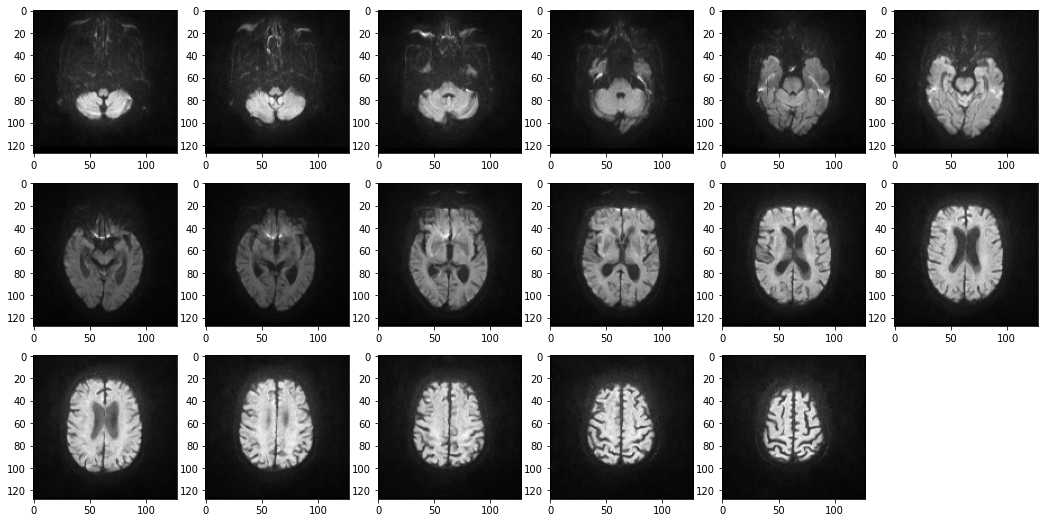

In [6]:
plot_slices(X[0], 0, "axial", "DWI")

# Import clinical and patient data

In [7]:
dat = pd.read_csv(DIR + DATA_DIR + "data_bern_25_11_2020_dwi.csv")
dat.head(3)

,p_id,columns,instance_no,path,rows,sequence,modality,modality_no,folder,image,...,time_to_needle,time_to_groin_puncture,vessel_open_before_therapy,tici,tici_binary,toast,p_id_old,pixel_spacing_x,pixel_spacing_y,pixel_spacing_z
0,442968,192,20,D:\AIM_EXPORT\0000442968\13936379\0000442968_1...,192,ep2d_diff_3scan_trace_p2,DWI,2,13936379,1277138618,...,non,240.0,0,4,1,2,442968,1.197917,1.197917,5.0
1,516341,128,23,D:\AIM_EXPORT\0000516341\13946886\0000516341_1...,128,ep2d_diff_M128_b0_1000_DIN,DWI,1,13946886,1278003845,...,non,211.0,0,4,1,5,516341,1.796875,1.796875,5.0
2,653853,128,26,D:\AIM_EXPORT\0000653853\13960789\0000653853_1...,128,ep2d_diff_M128_b0_1000_DIN,DWI,1,13960789,1279008923,...,non,140.0,0,4,1,4,653853,1.796875,1.796875,5.0


In [8]:
# add image information to define the expert model as in the paper with Janne
dat1 = pd.read_csv(DIR + DATA_DIR + "data_wide_all_nihss.csv", sep = ",")
dat1.head(3)

# check if the patient IDs between datasets match
print(all(dat.p_id.values == dat1.p_id.values))

# attach values 
dat["S_Medm_rbf"] = dat1.S_Medm_rbf.values
dat["volume_adc"] = dat1.volume_adc.values
dat["volume_tar"] = dat1.volume_tar.values
dat["infarct_side"] = dat1.infarct_side

True


In [9]:
# Size of the dataframe: same as the images
dat.shape
dat.head(3)

,p_id,columns,instance_no,path,rows,sequence,modality,modality_no,folder,image,...,tici,tici_binary,toast,p_id_old,pixel_spacing_x,pixel_spacing_y,pixel_spacing_z,S_Medm_rbf,volume_adc,volume_tar
0,442968,192,20,D:\AIM_EXPORT\0000442968\13936379\0000442968_1...,192,ep2d_diff_3scan_trace_p2,DWI,2,13936379,1277138618,...,4,1,2,442968,1.197917,1.197917,5.0,11.351128,0.00,55.73
1,516341,128,23,D:\AIM_EXPORT\0000516341\13946886\0000516341_1...,128,ep2d_diff_M128_b0_1000_DIN,DWI,1,13946886,1278003845,...,4,1,5,516341,1.796875,1.796875,5.0,26.606539,24.05,166.33
2,653853,128,26,D:\AIM_EXPORT\0000653853\13960789\0000653853_1...,128,ep2d_diff_M128_b0_1000_DIN,DWI,1,13960789,1279008923,...,4,1,4,653853,1.796875,1.796875,5.0,36.334002,1.78,40.24


In [10]:
# define binary mRS
dat["mrs_3months_binary"] = 0
dat.loc[dat.mrs_3months <= 2, "mrs_3months_binary"] = 1

In [11]:
# define binary toast score
dat["toast_binary"] = 0
dat.loc[dat.toast == 2, "toast_binary"] = 1

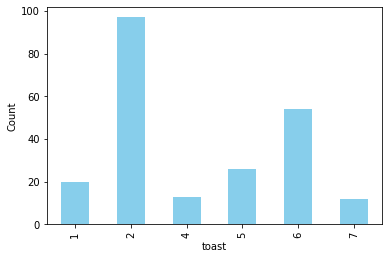

In [12]:
# show distr of toast Score (Stroke Cause)
class_counts = dat['toast'].value_counts().sort_index()
class_counts.plot(kind='bar', color='skyblue')
plt.xlabel('toast')
plt.ylabel('Count')
plt.show()


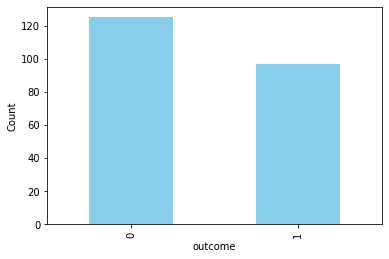

In [13]:
class_counts = dat['toast_binary'].value_counts().sort_index()
class_counts.plot(kind='bar', color='skyblue')
plt.xlabel('outcome')
plt.ylabel('Count')
plt.show()

#### Train, validation and test

In [14]:
# NAs?
[dat.age.isnull().sum(), 
 dat.nihss_bl.isnull().sum(),  
 dat.sys_bloodpressure_bl.isnull().sum(),
 dat.rf_diabetes.isnull().sum(), 
 dat.rf_hypertonia.isnull().sum(), 
 dat.rf_smoker.isnull().sum(),  
 dat.rf_tia_stroke.isnull().sum(), 
 dat.lyse.isnull().sum(),
 dat.time_to_groin_puncture.isnull().sum()]

[0, 0, 8, 0, 0, 20, 0, 0, 7]

In [14]:
# # simple imputation: replace all missing values with the mode of the column
# for column in dat.columns:
#     dat[column].fillna(dat[column].mode()[0], inplace=True)

In [15]:
# use the imputed data from the last project
train0 = pd.read_csv(DIR + DATA_DIR + "train_imputed_all1.csv", sep = ",")
train1 = pd.read_csv(DIR + DATA_DIR + "train_imputed_all2.csv", sep = ",")
train2 = pd.read_csv(DIR + DATA_DIR + "train_imputed_all3.csv", sep = ",")
train3 = pd.read_csv(DIR + DATA_DIR + "train_imputed_all4.csv", sep = ",")
train4 = pd.read_csv(DIR + DATA_DIR + "train_imputed_all5.csv", sep = ",")

test0 = pd.read_csv(DIR + DATA_DIR + "test_imputed_all1.csv", sep = ",")
test1 = pd.read_csv(DIR + DATA_DIR + "test_imputed_all2.csv", sep = ",")
test2 = pd.read_csv(DIR + DATA_DIR + "test_imputed_all3.csv", sep = ",")
test3 = pd.read_csv(DIR + DATA_DIR + "test_imputed_all4.csv", sep = ",")
test4 = pd.read_csv(DIR + DATA_DIR + "test_imputed_all5.csv", sep = ",")

In [16]:
train = [train0, train1, train2, train3, train4]
test = [test0, test1, test2, test3, test4]

In [17]:
# get training and test indices for CV later to impute during CV
train_idxes0 = [train0.index.values, train1.index.values, train2.index.values, train3.index.values, train4.index.values]
test_idxes = [test0.index.values, test1.index.values, test2.index.values, test3.index.values, test4.index.values]

In [18]:
my_seed = 3004

# define validation data
train_idxes = []
valid_idxes = []
for i in range(5):
    np.random.seed(my_seed)
    train_idx, valid_idx = train_test_split(train_idxes0[i], test_size = int(len(train_idxes0[i])*0.15))
    print(valid_idx)
    valid_idxes.append(np.sort(valid_idx))
    train_idxes.append(np.sort(train_idx))
    my_seed += 1
    
# define datasets: train and validation
train_old = train
train = []
valid = []
for f in range(5):
    train.append(train_old[f].loc[train_old[f].index.isin(train_idxes[f]),:])
    valid.append(train_old[f].loc[train_old[f].index.isin(valid_idxes[f]),:])

# get patient IDs
for i in range(5):
    train[i] = train[i].assign(p_id = dat.p_id[train_idxes[i]-1].values)
    valid[i] = valid[i].assign(p_id = dat.p_id[valid_idxes[i]-1].values)
    test[i] = test[i].assign(p_id = dat.p_id[test_idxes[i]-1].values)
    
# get toast score
for i in range(5):
    train[i] = train[i].assign(toast = dat.toast[train_idxes[i]-1].values)
    valid[i] = valid[i].assign(toast = dat.toast[valid_idxes[i]-1].values)
    test[i] = test[i].assign(toast = dat.toast[test_idxes[i]-1].values)

[ 49 110  98  83  18 141 134 218 221  44 139 108  65   4  57 104 151  60
  54 194   3 130 156 128 212 114]
[146  84  56  49 188  95 106 147 139  26  53 133 183 152 155 143 207  88
   5 206 102 179 120 128  65 181]
[ 34  41  96  35 188  53  57 190 120  69  40   3  45 146  59 134 220 127
 130  64  78 108 153   4  21 165]
[214 185  12  55 178  36 166  76 133  82 153  26  73 141 118 107  81 139
 115  70 123  31  83 197  69 184]
[122   4  98 219 107  97 191 156  67  93 113  91 130 169 134 153  63  77
 148  40  35 116 183 171 212  45]


In [22]:
# check if indices overlap
# np.sort(train[0].index.values)
# np.sort(valid[0].index.values)
# np.sort(test[0].index.values)

In [23]:
# save imputed datasets with p_id, toast and image information
#for i in range(5):
#    train[i].to_csv(DIR + DATA_DIR + "train_imputed_all" + str(i) + "_cause.csv", sep = ",")
#for i in range(5):
#    test[i].to_csv(DIR + DATA_DIR + "test_imputed_all" + str(i) + "_cause.csv", sep = ",")

In [24]:
# #  check if image data still corresponds to tables --> works
# for i in range(5):
#     print(all(train[i].age.values.round(2) == dat.age.values[train_idxes[i]-1].round(2)))
#     print(all(valid[i].age.values.round(2) == dat.age.values[valid_idxes[i]-1].round(2)))
#     print(all(test[i].age.values.round(2) == dat.age.values[test_idxes[i]-1].round(2)))

In [19]:
Y = np.array(dat.toast_binary)
print(Y[0:5])
print(Y.shape)
Y_cat = to_categorical(Y)
print(Y_cat[0:5])
print(Y_cat.shape)


[1 0 0 1 0]
(222,)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
(222, 2)


# Define models

In [20]:
def img_model_3D(input_shape, output_shape, input_name, activation = "linear"): # Input shape: (128, 128, 20, 3)
    in_ = keras.Input(shape = input_shape, name = input_name)
    x = layers.Convolution3D(32, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(in_)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.Convolution3D(32, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.Convolution3D(64, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.Convolution3D(64, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.Convolution3D(128, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Dropout(0.3)(x)
    out_ = layers.Dense(output_shape, activation = activation, use_bias = False)(x)
    nn_im = keras.Model(inputs = in_, outputs = out_)
    return nn_im

mod = img_model_3D(X.shape[1:], 1, 'im_in', 'sigmoid')
mod.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
im_in (InputLayer)           [(None, 128, 128, 20, 3)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 128, 128, 20, 32)  2624      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 20, 32)  128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 64, 64, 10, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 64, 10, 32)    27680     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 10, 32)    128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 32, 5, 32)     0     

In [21]:
X.shape[0:]

(222, 128, 128, 20, 3)

# Image Data

## Training

In [21]:
folder_name = "ONTRAM_toast_binary_Img/"
batch_size = 8
C = 2 # binary outcome
epochs = 300
# # create folders: run only once
#os.mkdir(OUTPUT_DIR + folder_name)
#for i in range(5):
#    os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i))
#    for j in range(5):
#        os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i) + "/run" + str(j))

In [22]:
# function for plots while training
from functions.keras_training_progress import PlotLearning

In [23]:
# def function for preprocessing
def train_preprocessing(data, label):
    """Process training data."""
    volume = data # shift: image
    volume = zoom(volume)
    volume = rotate(volume)
    volume = shift(volume)
    volume = flip(volume)
    return (volume), label

In [ ]:
# Train all 5 folds

for f in range(0,5):
    
    # Load data for fold f
    train_idx = train_idxes[f]
    test_idx = test_idxes[f]
    valid_idx = valid_idxes[f]

    X_train = X[train_idx-1]
    X_valid = X[valid_idx-1]
    X_test = X[test_idx-1]

    Y_train = Y_cat[train_idx-1]
    Y_valid = Y_cat[valid_idx-1]
    Y_test = Y_cat[test_idx-1]

    dat_train = train[f]
    dat_valid = valid[f]
    dat_test = test[f]

    dat_train.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(f) + "/" + "dat_train.csv", index = False)
    dat_valid.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(f) + "/" + "dat_valid.csv", index = False)
    dat_test.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(f) + "/" + "dat_test.csv", index = False)    


    # Define datasets

    train_data = tf.data.Dataset.from_tensor_slices((X_train))
    train_labels = tf.data.Dataset.from_tensor_slices((Y_train))

    valid_data = tf.data.Dataset.from_tensor_slices((X_valid))
    valid_labels = tf.data.Dataset.from_tensor_slices((Y_valid))

    test_data = tf.data.Dataset.from_tensor_slices((X_test))
    test_labels = tf.data.Dataset.from_tensor_slices((Y_test))

    train_loader = tf.data.Dataset.zip((train_data, train_labels))
    validation_loader = tf.data.Dataset.zip((valid_data, valid_labels))
    test_loader = tf.data.Dataset.zip((test_data, test_labels))

    train_dataset = (train_loader.shuffle(len(X_train))
                     .map(train_preprocessing)
                     .batch(batch_size, drop_remainder = True))
    validation_dataset = (validation_loader.batch(batch_size, drop_remainder = True))
    
    test_dataset = (test_loader.batch(len(X_test)))


    # define ONTRAM model for image data only (binary, complex intercept)
    
    img_model = img_model_3D(X_train.shape[1:], C-1, 'im_in', 'linear')
    model = ontram(img_model)

    # compile and train
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-5),
                loss = ontram_loss(C, batch_size),
                metrics = [ontram_acc(C, batch_size)])

    checkpoint_filepath = OUTPUT_DIR + folder_name + "fold" + str(f) + "/" + "run" + str(0) + "/"

    checkpoint_cb = keras.callbacks.ModelCheckpoint(
                filepath = checkpoint_filepath + "model_weights.hdf5",
                save_weights_only = True,
                monitor = "val_loss",
                mode = 'min',
                save_best_only = True)
    
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
    
    callbacks_list = [checkpoint_cb, early_stopping_cb]
    
    
    history = model.fit(train_dataset,
                        validation_data = validation_dataset,
                        epochs = epochs,
                        shuffle = True,
                        verbose = 2,
                        callbacks=callbacks_list)

    pd.DataFrame(history.history).to_csv(checkpoint_filepath + "history.csv", index = False)
    #model.save_weights(checkpoint_filepath + "model_weights.hdf5")

Epoch 1/300


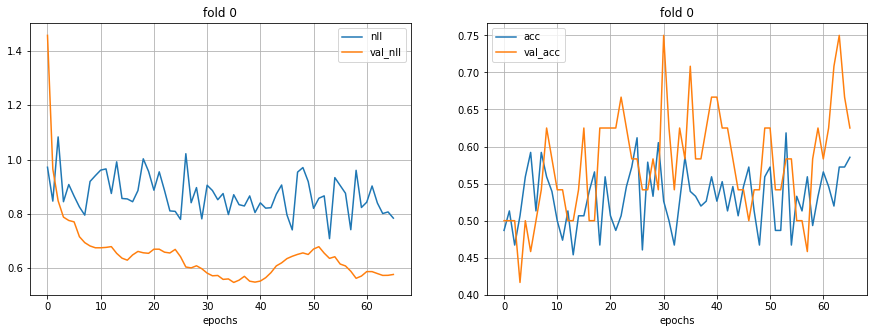

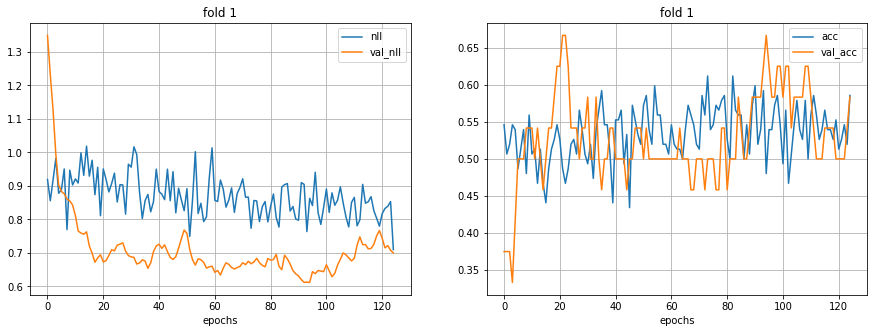

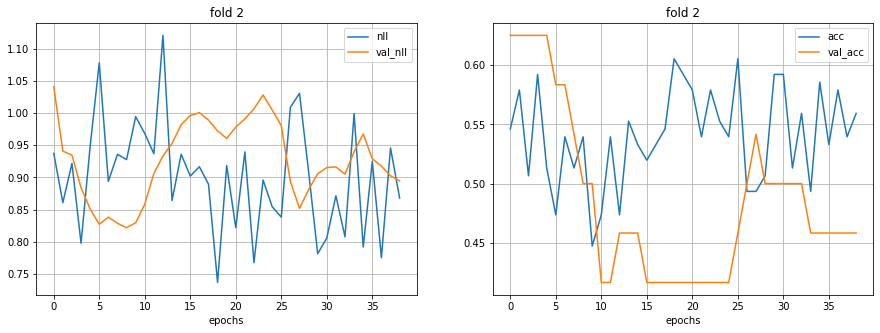

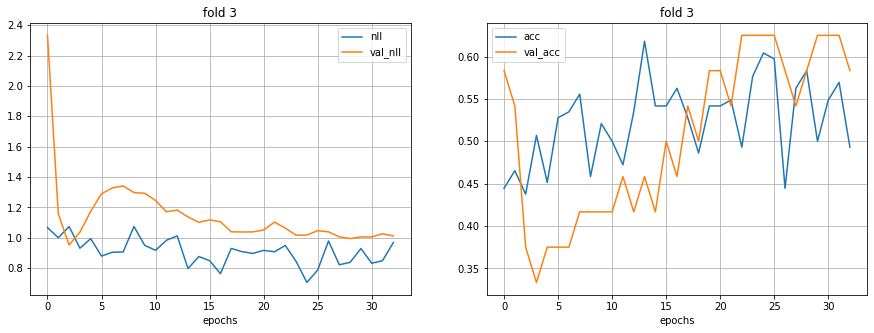

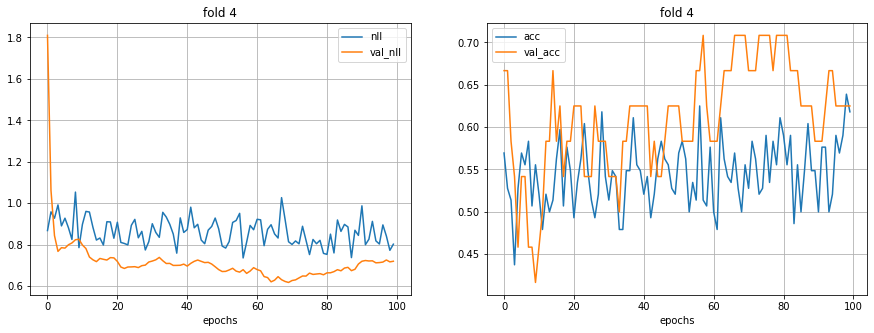

In [25]:
# plot training history for fold f

for f in range(0,5):
    cfp = OUTPUT_DIR + folder_name + "fold" + str(f) + "/" + "run" + str(0) + "/"
    hist = pd.read_csv(cfp + "history.csv")

    plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    plt.plot(hist['loss'], label = "nll")
    plt.plot(hist['val_loss'],label = "val_nll")
    plt.legend()
    plt.grid()
    plt.xlabel('epochs')
    plt.title("fold " + str(f))
    plt.subplot(1,2,2)
    plt.plot(hist['acc'], label = "acc")
    plt.plot(hist['val_acc'],label = "val_acc")
    plt.xlabel('epochs')
    plt.legend()
    plt.grid()
    plt.title("fold " + str(f))
    plt.show()

In [27]:
img_model = img_model_3D(X_train.shape[1:], C-1, 'im_in', 'linear')
model = ontram(img_model)

# compile and train
model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-5),
            loss = ontram_loss(C, batch_size),
            metrics = [ontram_acc(C, batch_size)])

import warnings
warnings.filterwarnings("ignore")


for f in range(0,5):
    cfp = OUTPUT_DIR + folder_name + "fold" + str(f) + "/" + "run" + str(0) + "/"
    
    train_idx = train_idxes[f]
    test_idx = test_idxes[f]
    valid_idx = valid_idxes[f]

    X_train = X[train_idx-1]
    X_valid = X[valid_idx-1]
    X_test = X[test_idx-1]

    Y_train = Y_cat[train_idx-1]
    Y_valid = Y_cat[valid_idx-1]
    Y_test = Y_cat[test_idx-1]

    dat_train = train[f]
    dat_valid = valid[f]
    dat_test = test[f]    

    # Define datasets

    train_data = tf.data.Dataset.from_tensor_slices((X_train))
    train_labels = tf.data.Dataset.from_tensor_slices((Y_train))

    valid_data = tf.data.Dataset.from_tensor_slices((X_valid))
    valid_labels = tf.data.Dataset.from_tensor_slices((Y_valid))

    test_data = tf.data.Dataset.from_tensor_slices((X_test))
    test_labels = tf.data.Dataset.from_tensor_slices((Y_test))

    train_loader = tf.data.Dataset.zip((train_data, train_labels))
    validation_loader = tf.data.Dataset.zip((valid_data, valid_labels))
    test_loader = tf.data.Dataset.zip((test_data, test_labels))

    train_dataset = (train_loader.shuffle(len(X_train))
                     .map(train_preprocessing)
                     .batch(batch_size, drop_remainder = True))
    validation_dataset = (validation_loader.batch(batch_size, drop_remainder = True))
    
    test_dataset = (test_loader.batch(len(X_test)))
    
    
    # Do predictions for each fold
    
    hist = pd.read_csv(cfp + "history.csv")
    model.load_weights(cfp + "model_weights.hdf5")
    
    test_batch_size = len(X_test)
    model.compile(loss = ontram_loss(C, test_batch_size))
    preds = predict_ontram(model, data = test_dataset)


    # save predictions/parameters for each fold
    
    cdf = pd.DataFrame(preds["cdf"])
    cdf.columns = ["y_pred" + str(i) for i in range(C+1)]
    cdf["p_id"] = dat_test.p_id.values
    cdf["y_true"] = np.argmax(Y_test, axis=1)
    cdf.to_csv(cfp + "cdf.csv", index = False) 

    pdf = pd.DataFrame(preds["pdf"])
    pdf.columns = ["y_pred" + str(i) for i in range(C)]
    pdf["p_id"] = dat_test.p_id.values
    pdf["y_true"] = np.argmax(Y_test, axis=1)
    pdf["y_pred"] = tf.argmax(preds["pdf"], axis = 1)
    pdf.to_csv(cfp + "pdf.csv", index = False)

    nll = preds["nll"]
    acc = skm.accuracy_score(pdf.y_true, pdf.y_pred)
    auc = skm.roc_auc_score(y_true = pdf.y_true, y_score = pdf.y_pred)

    score_matrix = [
        ["Accuracy", round(acc, 2)],
        ["AUC", round(auc,2)],
        ["NLL", round(nll,2)]
    ]

    for row in score_matrix:
        print("{:<10} {:<10}".format(row[0], row[1]))

Accuracy   0.5       
AUC        0.49      
NLL        0.8600000143051147
Accuracy   0.5       
AUC        0.5       
NLL        0.8199999928474426
Accuracy   0.57      
AUC        0.5       
NLL        0.800000011920929
Accuracy   0.44      
AUC        0.43      
NLL        0.8799999952316284
Accuracy   0.73      
AUC        0.74      
NLL        0.6399999856948853


In [45]:
#print(preds["cdf"][1, :])
#print(preds["pdf"][1, :])
#print(preds["nll"])
#print(preds["cdf"][1, 1:] - preds["cdf"][1, :-1])
#print(tf.argmax(preds["pdf"], axis = 1))

[0.         0.45454988 1.        ]
[0.45454988 0.5454501 ]
0.69437826
[0.45454988 0.5454501 ]
tf.Tensor(
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0], shape=(44,), dtype=int64)


In [53]:
valid_idx = valid_idxes[0]
X_valid = X[valid_idx-1]
Y_valid = Y_cat[valid_idx-1]
dat = valid[0]
dat['toast']

3      4
4      2
18     2
44     2
49     5
54     4
57     5
60     1
65     2
83     2
98     2
104    2
108    2
110    6
114    6
128    5
130    5
134    6
139    2
141    6
151    2
156    5
194    2
212    2
218    6
221    6
Name: toast, dtype: int64

In [54]:
Y_valid

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [55]:
X.shape

(222, 128, 128, 20, 3)